In [ ]:
#from google.colab import drive
#drive.mount('/content/google_drive')

Mounted at /content/google_drive


In [ ]:
print('\n-----------------------------------------------------------------------------------------------')
print('( ) Loading libraries')
print('-----------------------------------------------------------------------------------------------')
!python -m pip install rioxarray==0.14.1 &> /dev/null


-----------------------------------------------------------------------------------------------
( ) Loading libraries
-----------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
import os
import json
import geopandas as gpd
import shutil
import rioxarray as rxr
import matplotlib.pyplot as plt
from glob import glob
# Earth Engine
import ee
import requests

In [ ]:
def check_projection(shp_file_path):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1) Check projection of shapefile')
  print('-----------------------------------------------------------------------------------------------')
  # find name of shapefile
  for shp_file in os.listdir(os.path.join(shp_file_path)):
      if shp_file.endswith(".shp"):
        shp_file_name = shp_file
  print('Shapefile name: ', shp_file_name)
  print('Shapefile path: ', os.path.join(variable['main_dir'], "shapefile",shp_file_name))
  shp_lyr_check = gpd.read_file(os.path.join(variable['main_dir'], "shapefile",shp_file_name))
  print('Shapefile CRS: ', shp_lyr_check.crs)

  temp_dir = os.path.join(variable['temporary_dir'])
  if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

  if shp_lyr_check.crs != 'EPSG:4326':
    # reproject
    shp_lyr_crs = shp_lyr_check.to_crs(epsg=4326)
    shp_lyr_crs.to_file(os.path.join(variable['temporary_dir'],shp_file_name))
    print('Shapefile layer has been reprojected to match shapefile')
  else:
    shp_lyr_crs = shp_lyr_check
    print('Coordinate systems match!')
    shp_lyr_crs.to_file(os.path.join(variable['temporary_dir'],shp_file_name))

  return(shp_file_name)

In [ ]:
def download_landcover(shp_file_path, shp_file_name, data_source, year_of_interest, band_name, scale):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1a) Download Landcover')
  print('-----------------------------------------------------------------------------------------------')
  # trigger the authentication flow
  ee.Authenticate()
  # initialize the library
  ee.Initialize()
  # define buffer
  buffer_size = 0.3

  # determine the boundary of the provided shapefile
  bounds = gpd.read_file(os.path.join(shp_file_path, shp_file_name)).bounds
  west, south, east, north = bounds = bounds.loc[0]
  west -= buffer_size
  south -= buffer_size
  #north -= buffer_size
  #east -= buffer_size
  print('Bounding box: ',west, south, east, north)

  # concat input data to generate full path
  full_data_source = data_source+'/'+year_of_interest+'_01_01'

  img = ee.Image(full_data_source)
  region = ee.Geometry.BBox(west, south, east, north)

  # Multi-band GeoTIFF file.
  url = img.getDownloadUrl({
      'bands': band_name,
      'region': region,
      'scale': scale,
      'format': 'GEO_TIFF'
  })

  # define output directory
  landcov_dir = os.path.join(variable['temporary_dir'],'Landcover')
  if not os.path.exists(landcov_dir):
    os.makedirs(landcov_dir)

  response = requests.get(url)
  with open(os.path.join(landcov_dir,'study_area_landcov.tif'), 'wb') as fd:
    fd.write(response.content)

  # path to clipped output file
  clipped_bounds = os.path.join(landcov_dir, 'study_area_landcov.tif')
  return(landcov_dir)

In [ ]:
def overlay_shp_on_landcov(shp_file_path, shp_file_name):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(2) Overlay shapefile on landcover')
  print('-----------------------------------------------------------------------------------------------')
  # find name of raster
  for tif_file in os.listdir(os.path.join(variable['temporary_dir'],'Landcover')):
      if tif_file.endswith(".tif"):
        tif_file_name = tif_file
  # open raster
  landcov_lyr = rxr.open_rasterio(os.path.join(variable['temporary_dir'],'Landcover',tif_file_name), masked=True).squeeze()
  # load shapefile
  crop_extent= gpd.read_file(os.path.join(variable['temporary_dir'], shp_file_name))

  print('Shapefile CRS: ', crop_extent.crs)
  print('Landcover CRS: ', landcov_lyr.rio.crs)

  if crop_extent.crs !=  landcov_lyr.rio.crs:
    # reproject
    landcov_lyr = landcov_lyr.rio.reproject(crop_extent.crs)
    print('Landcover layer has been reprojected to match shapefile')
  else:
    print('Coordinate systems match!')

  f, ax = plt.subplots(figsize=(10, 5))
  landcov_lyr.plot.imshow(ax=ax)

  crop_extent.plot(ax=ax,alpha=.8, color="black")
  ax.set(title="Raster Layer with Shapefile Overlayed")

  ax.set_axis_off()

  landcov_shapfile_visualization = True

  if landcov_shapfile_visualization == True:
    plt.show()
  return(landcov_lyr, crop_extent)

In [ ]:
def clip_and_format(landcov_dir, landcov_lyr, crop_extent):
  print('\n-----------------------------------------------------------------------------------------------')
  print('(3) Clip and format landcover into shapefile')
  print('-----------------------------------------------------------------------------------------------')
  # open crop extent (the study area extent boundary)
  crop_extent1 = crop_extent.buffer(.001)

  # clip the DEM layer
  lidar_clipped = landcov_lyr.rio.clip(crop_extent1, crop_extent1.crs)
  print('Landcover layer has been clipped')

  # save clipped DEM layer to drive
  path_to_tif_file = os.path.join(landcov_dir, 'clipped_lyr.tif')
  lidar_clipped.rio.to_raster(path_to_tif_file)
  print('Layer has been saved to temporary folder')

  # define Pathways Necessary for GDAL Commands
  # name of shapefile
  clip_name = 'studyArea_outline'

  # path to clipped output file
  clipped = os.path.join(landcov_dir, 'clipped.tif')

  # path to cleaned and clipped output file
  clipped_lyr = os.path.join(landcov_dir, 'clipped_lyr.tif')

  # path to landcover shapefile
  landcov_shp = os.path.join(landcov_dir, 'studyArea_landcov.shp')

  # define bash script directory
  bash_dir = os.path.join(variable['temporary_dir'],'bash_scripts')
  bash_path = os.path.isdir(bash_dir)
  if not bash_path:
    os.makedirs(bash_dir)
    print("created  folder: ", bash_dir)

  # gdal polygonize
  with open(os.path.join(bash_dir,'polygon.sh'), 'w') as f3:
      print(f'gdal_polygonize.py "{clipped_lyr}" "{landcov_shp}" -b 1 -f "ESRI Shapefile"', file=f3)
  # define bash command path
  polygon_sh = os.path.join(bash_dir, 'polygon.sh')

  # run bash command
  !bash {polygon_sh}

In [ ]:
def format_google_earth_data():
  print('\n-----------------------------------------------------------------------------------------------')
  print('(3a) Format landcover attribute names')
  print('-----------------------------------------------------------------------------------------------')
  # find name of shapefile
  for land_shp_file in os.listdir(landcov_dir):
      if land_shp_file.endswith(".shp"):
        land_shp_file_name = land_shp_file
  landcov_shp = gpd.read_file(os.path.join(landcov_dir, land_shp_file_name))
  landcov_dissolve = landcov_shp.dissolve(by='DN')
  landcov_dissolve["Landuse_ID"]= landcov_dissolve.index
  landcov_final = landcov_dissolve.reset_index()
  landcov_final = landcov_final.drop('DN', axis=1)

  land_output_dir = os.path.join(variable['main_dir'],'workflow_outputs', '1_HRU_data', 'Landcover')
  if not os.path.exists(land_output_dir):
    os.makedirs(land_output_dir)

  # save final landcover shapefile to drive
  landcov_final.to_file(os.path.join(land_output_dir,'studyArea_landcover.shp'))

In [ ]:
def visualize_landcover():
  print('\n-----------------------------------------------------------------------------------------------')
  print('(4) Visualize landcover outputs')
  print('-----------------------------------------------------------------------------------------------')
  landcov_dir_out = os.path.join(variable['main_dir'], 'workflow_outputs', '1_HRU_data', 'Landcover')
  # find name of shapefile
  for land_shp_file in os.listdir(landcov_dir_out):
      if land_shp_file.endswith(".shp"):
        land_shp_file_name = land_shp_file

  landcov_final = gpd.read_file(os.path.join(landcov_dir_out,land_shp_file_name))
  #print table
  display(landcov_final)

  f, ax = plt.subplots(figsize=(8,9))
  landcov_final.plot(column='Landuse_ID',categorical=True,legend=True ,ax=ax)
  ax.set_axis_off()
  plt.show()

  landcov_final['area'] = landcov_final.area

  df_L1 = pd.DataFrame(landcov_final.drop(columns='geometry'))
  df_landcov = df_L1.groupby('Landuse_ID').sum()
  df_landcov.reset_index(inplace=True)
  # collect unique landcover IDs
  unique_landcov = df_landcov['Landuse_ID'].unique()
  # get length of unique landcover IDs
  un_landcov_len_lst = list(range(unique_landcov.size))

  # compute general area percentage for each landcover type
  for val_L in unique_landcov:
    area_poly_L = df_landcov.loc[df_landcov['Landuse_ID'] == val_L, 'area']
    landcov_area = float((area_poly_L/df_landcov['area'].sum())*100)
    for num in un_landcov_len_lst:
      if val_L == unique_landcov[num]:
        print(f'ID ({val_L}): {round(landcov_area,2)}%')

  print('\n-----------------------------------------------------------------------------------------------')
  print('(4) Landcover is complete!')
  print('-----------------------------------------------------------------------------------------------')

In [ ]:
def upload_landcover(land_temp_dir):
  # find name of shapefile
  for shp_file in os.listdir(os.path.join(variable['main_dir'], 'shapefile')):
      if shp_file.endswith(".shp"):
        shp_file_name = shp_file

  # find name of shapefile
  for landcov_file in os.listdir(land_temp_dir):
      if landcov_file.endswith(".shp"):
        landcov_file_name = landcov_file

  print('\n-----------------------------------------------------------------------------------------------')
  print('(2) Check Projection')
  print('-----------------------------------------------------------------------------------------------')

  # load study area shapefile
  shp_extent = gpd.read_file(os.path.join(variable['main_dir'], 'shapefile', shp_file_name))
  # load landcover shapefile
  landcov_extent = gpd.read_file(os.path.join(land_temp_dir, landcov_file_name))
  if 'Landuse_ID' in landcov_extent:
    if shp_extent.crs !=  landcov_extent.crs:
      # reproject
      landcov_lyr = landcov_extent.to_crs(shp_extent.crs)
      print('\nLandcover layer has been reprojected to match shapefile')
    else:
      landcov_lyr = landcov_extent
      print('\nCoordinate systems match')

    print('\n-----------------------------------------------------------------------------------------------')
    print('(3) Visualize and save landcover layer')
    print('-----------------------------------------------------------------------------------------------')

    # check out table
    display(landcov_lyr)

    # visualize landcover
    f, ax = plt.subplots(figsize=(8,9))
    landcov_lyr.plot(column='Landuse_ID',categorical=True,legend=True ,ax=ax)
    ax.set_axis_off()
    plt.show()

    landcov_lyr['area'] = landcov_lyr.area

    df_L1 = pd.DataFrame(landcov_lyr.drop(columns='geometry'))
    df_landcov = df_L1.groupby('Landuse_ID').sum()
    df_landcov.reset_index(inplace=True)
    # collect unique landcover IDs
    unique_landcov = df_landcov['Landuse_ID'].unique()
    # get length of unique landcover IDs
    un_landcov_len_lst = list(range(unique_landcov.size))

    # compute general area percentage for each landcover type
    for val_L in unique_landcov:
      area_poly_L = df_landcov.loc[df_landcov['Landuse_ID'] == val_L, 'area']
      landcov_area = float((area_poly_L/df_landcov['area'].sum())*100)
      for num in un_landcov_len_lst:
        if val_L == unique_landcov[num]:
          print(f'ID ({val_L}): {round(landcov_area,2)}%')

    # save final landcover shapefile to drive
    landcov_output_dir = os.path.join(variable['main_dir'], 'workflow_outputs', '1_HRU_data','Landcover')
    if not os.path.exists(landcov_output_dir):
      os.makedirs(landcov_output_dir)
    landcov_lyr.to_file(os.path.join(landcov_output_dir,'studyArea_landcover.shp'))
  else:
    print('--- Invalid landuse column name ---\n')
    print('please change landuse column name to Landuse_ID and run again')

In [ ]:
def remove_temp_data():
  if os.path.exists(os.path.join(variable['temporary_dir'])):
    shutil.rmtree(os.path.join(variable['temporary_dir']))

In [ ]:
main_dir = '/content/google_drive/MyDrive/Developers_Magpie_Workflow'

with open(os.path.join(main_dir,"configuration_file.json"), "r") as f:
    variable = json.load(f)


-----------------------------------------------------------------------------------------------
(1) Upload Landcover
-----------------------------------------------------------------------------------------------
drag-and-drop landcover file into following folder: /content/google_drive/MyDrive/Developers_Magpie_Workflow/temporary_data/Landcover
Have you uploaded the landcover file (yes or no): yes

-----------------------------------------------------------------------------------------------
(1) Check projection of shapefile
-----------------------------------------------------------------------------------------------
Shapefile name:  studyArea_outline.shp
Shapefile path:  /content/google_drive/MyDrive/Developers_Magpie_Workflow/shapefile/studyArea_outline.shp
Shapefile CRS:  EPSG:4326
Coordinate systems match!

-----------------------------------------------------------------------------------------------
(2) Overlay shapefile on landcover
------------------------------------------

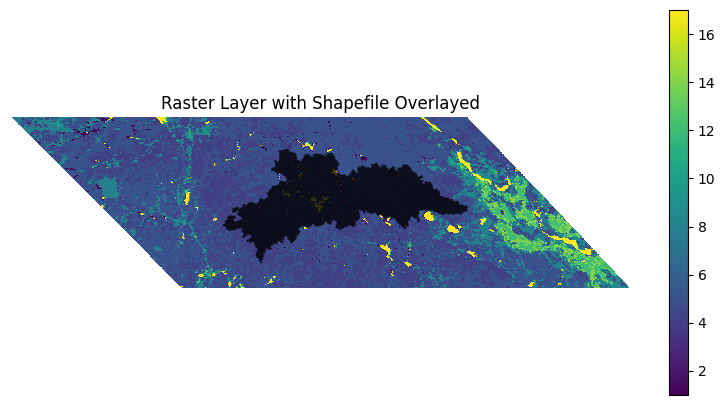


-----------------------------------------------------------------------------------------------
(3) Clip and format landcover into shapefile
-----------------------------------------------------------------------------------------------
Landcover layer has been clipped
Layer has been saved to temporary folder
created  folder:  /content/google_drive/MyDrive/Developers_Magpie_Workflow/temporary_data/bash_scripts


<ipython-input-7-b3622e304871>:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  crop_extent1 = crop_extent.buffer(.001)


Creating output /content/google_drive/MyDrive/Developers_Magpie_Workflow/temporary_data/Landcover/studyArea_landcov.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.

-----------------------------------------------------------------------------------------------
(4) Visualize landcover outputs
-----------------------------------------------------------------------------------------------


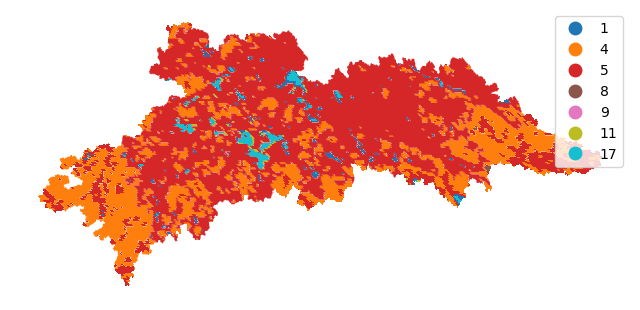

ID (1): 2.05%
ID (4): 30.39%
ID (5): 65.47%
ID (8): 0.1%
ID (9): 0.01%
ID (11): 0.38%
ID (17): 1.6%

-----------------------------------------------------------------------------------------------
(4) Landcover is complete!
-----------------------------------------------------------------------------------------------


<ipython-input-9-23134473ef94>:17: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  landcov_final['area'] = landcov_final.area


In [ ]:
if variable['generate_landcover'] == "yes" and variable['upload_landcover'] == "yes":
  print('Error: Please define whether you are using section 1d to generate the landcover layer OR upload your own, users cannot have both as yes')
elif variable['generate_landcover'] == 'yes' and variable['upload_landcover'] == 'no':
  shp_file_path = os.path.join(variable['main_dir'], 'shapefile')
  # step 1
  shp_file_name = check_projection(shp_file_path)
  # step 1a
  landcov_dir = download_landcover(shp_file_path, shp_file_name, variable["data_source_landcover"], variable["year_of_interest"],variable["band_name_landcover"], int(variable['scale_landcover']))
  # step 2
  landcov_lyr, crop_extent = overlay_shp_on_landcov(shp_file_path, shp_file_name)
  # step 3
  clip_and_format(landcov_dir, landcov_lyr, crop_extent)
  format_google_earth_data()
  # step 4
  visualize_landcover()
  # step 5
  remove_temp_data()
elif variable['generate_landcover'] == 'no' and variable['upload_landcover'] == 'yes':
  land_temp_dir = os.path.join(variable['temporary_dir'],'Landcover')
  if not os.path.exists(land_temp_dir):
    os.makedirs(land_temp_dir)
  print('\n-----------------------------------------------------------------------------------------------')
  print('(1) Upload Landcover')
  print('-----------------------------------------------------------------------------------------------')
  print(f'drag-and-drop landcover file into following folder: {land_temp_dir}')
  response = input("Have you uploaded the landcover file (yes or no): ")
  if response == "yes":
    for land_file in os.listdir(land_temp_dir):
      if land_file.endswith(".tif"):
        shp_file_path = os.path.join(variable['main_dir'], 'shapefile')
        # step 1
        shp_file_name = check_projection(shp_file_path)
        # step 2
        landcov_lyr, crop_extent = overlay_shp_on_landcov(shp_file_path, shp_file_name)
        # step 3
        clip_and_format(land_temp_dir, landcov_lyr, crop_extent)
        # step 4
        visualize_landcover()
        remove_temp_data()
      elif land_file.endswith(".shp"):
        upload_landcover(land_temp_dir)
        remove_temp_data()
else:
  print('( ) Landcover section has been skipped')